In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

plt.style.use("Solarize_Light2")

# Support Vector Machine:
### introduction:
The Support Vector Machine algorithm attempts to find a hyperplane in an N-Dimensional space (Where N is the number of
features) that distinctly classifies the data points under consideration.
There are many such hyperplanes possible, so our objective becomes finding the plane with the maximum margin, or
distance between data points of separate classes. Support vectors are data points that lie close to the hyperplane,
using their location we determine the hyperplane's position.

In [3]:
churn_data = pd.read_csv('/home/elliot/PycharmProjects/CSC 495 - Telecom Customer Churn/Datasets/telecom_churn_Processed.csv')

X = churn_data.drop('Churn', axis=1)

y = churn_data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 42)

First Iteration:

In [4]:
svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [5]:
y_pred_svc = svc.predict(X_test)
y_pred_train = svc.predict(X_train)

svc_train_as = metrics.accuracy_score(y_train, y_pred_train)
svc_as = metrics.accuracy_score(y_test, y_pred_svc)


In [6]:
print(f"Accuracy score for test data : {svc_as}")
print(f"Accuracy score for train data : {svc_train_as}")

Accuracy score for test data : 0.7371822490305903
Accuracy score for train data : 0.73275313097007


This seems like a good starting point for our model, the accuracy isn't great but it's not terrible. But on closer
inspection we find that there are some real issues in our model.

In [7]:
print(metrics.classification_report(y_test, y_pred_svc))


              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1711
           1       0.00      0.00      0.00       610

    accuracy                           0.74      2321
   macro avg       0.37      0.50      0.42      2321
weighted avg       0.54      0.74      0.63      2321



<AxesSubplot:>

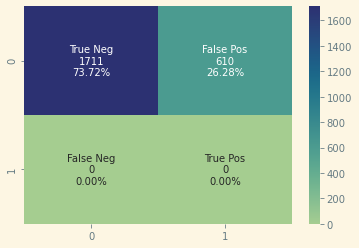

In [8]:
cf_matrix = metrics.confusion_matrix(y_pred_svc, y_test)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = [f"{value}" for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='crest')

The model is horrible, with our goal of identifying true positives for customer churn, it hasn't been able to find one.
We need to correct something, the most likely issue is non-standardized quantitative data in our dataset.
Let's see if we can do anything to improve these results, first we will scale our quantitative features.

In [9]:
# Now we Scale the data
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [10]:
svc_sc = SVC()
svc_sc.fit(X_train_sc, y_train)

y_pred_sc = svc_sc.predict(X_test_sc)
y_pred_sc_train = svc_sc.predict(X_train_sc)

svc_sc_train_as = metrics.accuracy_score(y_train, y_pred_sc_train)
svc_sc_as = metrics.accuracy_score(y_test, y_pred_sc)


<AxesSubplot:>

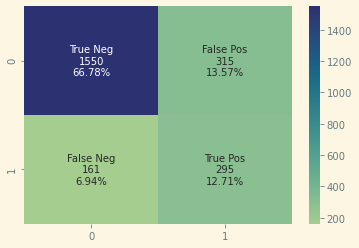

In [11]:
cf_matrix = metrics.confusion_matrix(y_pred_sc, y_test)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = [f"{value}" for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='crest')

In [12]:
print(f"Accuracy score for test data : {svc_sc_as}")
print(f"Accuracy score for train data : {svc_sc_train_as}")
print(metrics.classification_report(y_test, y_pred_sc))

Accuracy score for test data : 0.7949159844894442
Accuracy score for train data : 0.8227552536616429
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1711
           1       0.65      0.48      0.55       610

    accuracy                           0.79      2321
   macro avg       0.74      0.69      0.71      2321
weighted avg       0.78      0.79      0.78      2321



Standardizing our quantitative data using StandardScaler() has really improved the performance of our model, now we will
take this opportunity to tune the hyperparameters of our model, and see if we can improve performance further.

In [13]:
params = {'kernel' : ['rbf'], 'C' : [0.1, 1, 5, 10], 'gamma' : [0.01, 0.1, 0.9, 1]}

grid = GridSearchCV(SVC(), params, cv = 5, return_train_score= False)


In [14]:
svc_new = SVC(C = 1, gamma = 0.01, kernel = 'rbf')
svc_new.fit(X_train_sc, y_train)

y_pred_new = svc_new.predict(X_test_sc)
y_pred_new_train = svc_new.predict(X_train_sc)

svc_new_train_as = metrics.accuracy_score(y_train, y_pred_new_train)
svc_new_as = metrics.accuracy_score(y_test, y_pred_new)

print(f"Accuracy score for test data : {svc_new_as}")
print(f"Accuracy score for train data : {svc_new_train_as}")

print(metrics.classification_report(y_test, y_pred_new))

Accuracy score for test data : 0.7962085308056872
Accuracy score for train data : 0.8106559116960306
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1711
           1       0.65      0.49      0.56       610

    accuracy                           0.80      2321
   macro avg       0.74      0.70      0.71      2321
weighted avg       0.78      0.80      0.79      2321



Our model's performance has improved slightly, but the performance gain has not made the SVM model stand out compared
to other methods available. Here is the ROC curve for the SVM, which we will use to compare to other models in the
future:

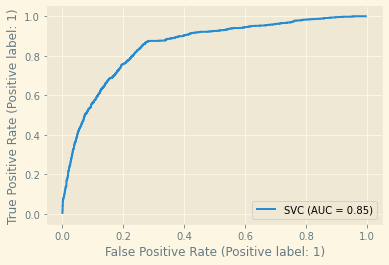

In [15]:
metrics.plot_roc_curve(svc_new, X_train_sc, y_train)

In [19]:
k = 5
kf = KFold(n_splits=k, random_state=None)

result = cross_val_score(svc_new , X_train_sc, y_train, cv = kf)
mean = round(result.mean()*100, 2)
stdv = round(result.std()*100, 2)
range = [round(mean-stdv, 2), round(mean+stdv ,2)]

print("Avg accuracy: {}% +/- {}%\n range: {}".format(mean, stdv, range))

Avg accuracy: 79.81% +/- 1.11%
 range: [78.7, 80.92]
